In [16]:
import re
import regex
import pandas as pd
import numpy as np
import emoji
import plotly.express as px
from collections import Counter
import matplotlib.pyplot as plt
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
#% matplotlib inline

In [17]:
pip install emoji

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\users\siddharth\python38\python.exe -m pip install --upgrade pip' command.


In [4]:
pip install plotly

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\users\siddharth\python38\python.exe -m pip install --upgrade pip' command.


### WhatsApp Group Chat Analysis

Although, the data is ready to use we still need to change the format of the date and time of messages which can be done easily. For this I will define a function that can detect whether each line starts with a date as it states that it is a unique message:

In [18]:
def startsWithDateAndTime(s):
    pattern = '^([0-9]+)(\/)([0-9]+)(\/)([0-9]+), ([0-9]+):([0-9]+)[ ]?(AM|PM|am|pm)? -' 
    result = re.match(pattern, s)
    if result:
        return True
    return False

In [23]:
#extract the usernames in the chats as Authors:

In [19]:
def FindAuthor(s):
  s=s.split(":")
  if len(s)==2:
    return True
  else:
    return False

Now, I will create a function to separate all the information from each other so that we could easily use the information as a pandas dataframe:

In [20]:
def getDataPoint(line):   
    splitLine = line.split(' - ') 
    dateTime = splitLine[0]
    date, time = dateTime.split(', ') 
    message = ' '.join(splitLine[1:])
    if FindAuthor(message): 
        splitMessage = message.split(': ') 
        author = splitMessage[0] 
        message = ' '.join(splitMessage[1:])
    else:
        author = None
    return date, time, author, message

In [21]:
parsedData = [] # List to keep track of data so it can be used by a Pandas dataframe
conversation = 'WhatsApp Chat with AMONG US.txt'
with open(conversation, encoding="utf-8") as fp:
    fp.readline() # Skipping first line of the file because contains information related to something about end-to-end encryption
    messageBuffer = [] 
    date, time, author = None, None, None
    while True:
        line = fp.readline() 
        if not line: 
            break
        line = line.strip() 
        if startsWithDateAndTime(line): 
            if len(messageBuffer) > 0: 
                parsedData.append([date, time, author, ' '.join(messageBuffer)]) 
            messageBuffer.clear() 
            date, time, author, message = getDataPoint(line) 
            messageBuffer.append(message) 
        else:
            messageBuffer.append(line)

put the data into a dataframe and have a look at the data:

In [22]:
df = pd.DataFrame(parsedData, columns=['Date', 'Time', 'Author', 'Message']) # Initialising a pandas Dataframe.
df["Date"] = pd.to_datetime(df["Date"])
df.tail(20)

,Date,Time,Author,Message
980,2021-10-11,9:49 am,Arpit Arora CSE tiet,iLoveMachineLearning@TIET69
981,2021-10-11,9:49 am,Raju Thapar,Bhai mai market gya tha ML. Ki class ke liye i...
982,2021-10-11,9:49 am,Arpit Arora CSE tiet,Sir se bolna daalkr try krein
983,2021-10-11,9:49 am,Raju Thapar,Aur bc ye dekhne ko. Mil rha hau
984,2021-10-11,9:49 am,Raju Thapar,🤣🤣🤣🤣
985,2021-10-11,9:50 am,Arpit Arora CSE tiet,Accident hojaata hai bhai aise nahi Krna chahiye
986,2021-10-11,9:50 am,Raju Thapar,Pahle hi sir ko try karna tha id ko
987,2021-10-11,9:50 am,Raju Thapar,🥲
988,2021-10-11,9:50 am,Raju Thapar,Gande log
989,2021-10-11,9:50 am,Anvesh Thapar,itna mat padha kar


The above dataframe looks good. Now let’s start with our WhatsApp group chat analysis.



In [24]:
#See all the authors
df.Author.unique()

array([None, 'Swapnil Thapar', 'Devansh Thapar', 'Raju Thapar',
       'Kirti Vardhman Thapar', 'Ikshul Thapar',
       'Divyansh Purohit Thapar', 'Navneet Thapar', '+91 97178 06952',
       'Riya Singhal Thapar', 'Aastik Thapar', 'Nishu Thapar',
       'Arpit Arora CSE tiet', '+91 99280 12208',
       'Nikita Manchanda Thapar', 'Anvesh Thapar', 'Sid', 'Palak Thapar',
       'Aditi Thapar', '+91 93521 86776', '+91 70183 50272',
       '+91 94605 61741', '+91 6307 136 642'], dtype=object)

Now let’s have some analysis by looking at the statistics. I will first create a function which will split the text and other media files from each other including emojis:

In [26]:
media_messages = df[df['Message'] == '<Media omitted>'].shape[0]
print(media_messages)
def split_count(text):

    emoji_list = []
    data = regex.findall(r'\X', text)
    for word in data:
        if any(char in emoji.UNICODE_EMOJI for char in word):
            emoji_list.append(word)

    return emoji_list

df["emoji"] = df["Message"].apply(split_count)
emojis = sum(df['emoji'].str.len())
print(emojis)
URLPATTERN = r'(https?://\S+)'
df['urlcount'] = df.Message.apply(lambda x: re.findall(URLPATTERN, x)).str.len()
links = np.sum(df.urlcount)
print("Data science Community")
#print("Messages:",total_messages)
print("Media:",media_messages)
print("Emojis:",emojis)
print("Links:",links)

105
0
Data science Community
Media: 105
Emojis: 0
Links: 10


author wise status from the WhatsApp group chat:

In [27]:
media_messages_df = df[df['Message'] == '<Media omitted>']
messages_df = df.drop(media_messages_df.index)
messages_df.info()
messages_df['Letter_Count'] = messages_df['Message'].apply(lambda s : len(s))
messages_df['Word_Count'] = messages_df['Message'].apply(lambda s : len(s.split(' ')))
messages_df["MessageCount"]=1

l = ["Raju Thapar", "Riya Singhal Thapar", "Sid"]
for i in range(len(l)):
  # Filtering out messages of particular user
  req_df= messages_df[messages_df["Author"] == l[i]]
  # req_df will contain messages of only one particular user
  print(f'Stats of {l[i]} -')
  # shape will print number of rows which indirectly means the number of messages
  print('Messages Sent', req_df.shape[0])
  #Word_Count contains of total words in one message. Sum of all words/ Total Messages will yield words per message
  words_per_message = (np.sum(req_df['Word_Count']))/req_df.shape[0]
  print('Words per message', words_per_message)
  #media conists of media messages
  media = media_messages_df[media_messages_df['Author'] == l[i]].shape[0]
  print('Media Messages Sent', media)
  # emojis conists of total emojis
  emojis = sum(req_df['emoji'].str.len())
  print('Emojis Sent', emojis)
  #links consist of total links
  links = sum(req_df["urlcount"])   
  print('Links Sent', links)   
  print()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 895 entries, 0 to 999
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Date      895 non-null    datetime64[ns]
 1   Time      895 non-null    object        
 2   Author    865 non-null    object        
 3   Message   895 non-null    object        
 4   emoji     895 non-null    object        
 5   urlcount  895 non-null    int64         
dtypes: datetime64[ns](1), int64(1), object(4)
memory usage: 48.9+ KB
Stats of Raju Thapar -
Messages Sent 188
Words per message 4.175531914893617
Media Messages Sent 32
Emojis Sent 0
Links Sent 0

Stats of Riya Singhal Thapar -
Messages Sent 81
Words per message 3.1481481481481484
Media Messages Sent 13
Emojis Sent 0
Links Sent 0

Stats of Sid -
Messages Sent 19
Words per message 3.9473684210526314
Media Messages Sent 8
Emojis Sent 0
Links Sent 0



In [28]:
total_emojis_list = list([a for b in messages_df.emoji for a in b])
emoji_dict = dict(Counter(total_emojis_list))
emoji_dict = sorted(emoji_dict.items(), key=lambda x: x[1], reverse=True)
for i in emoji_dict:
  print(i)

### WhatsApp Group Chat Analysis: Word Cloud

Now, I will create a Word Cloud for our WhatsApp Group Chat Analysis, to see what the group is based on. A Word Cloud is a graph of words which shows the most used words by representing the most used words bigger than the rest:

There are 22577 words in all the messages.


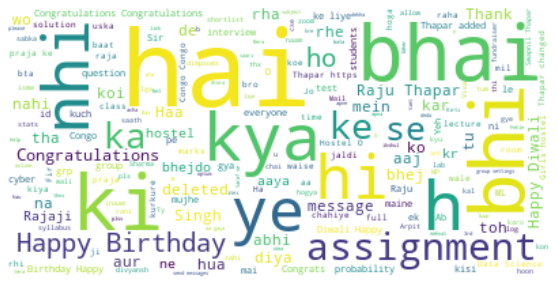

In [29]:
text = " ".join(review for review in messages_df.Message)
print ("There are {} words in all the messages.".format(len(text)))
stopwords = set(STOPWORDS)
# Generate a word cloud image
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)
# Display the generated image:
# the matplotlib way:
plt.figure( figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Author wise WordCloud

Author name Raju Thapar


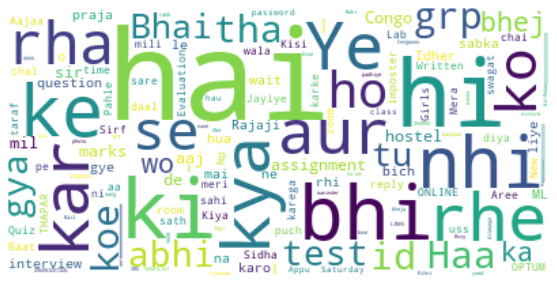

Author name Riya Singhal Thapar


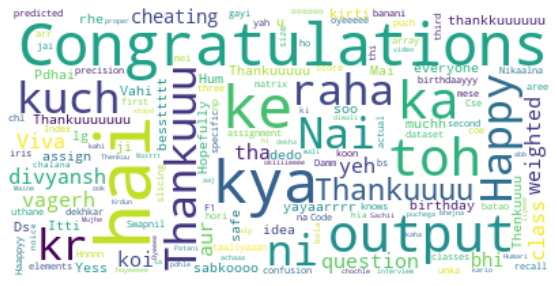

Author name Sid


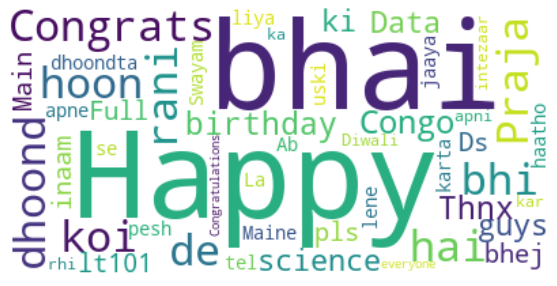

In [30]:
l = ["Raju Thapar", "Riya Singhal Thapar", "Sid"]
for i in range(len(l)):
  dummy_df = messages_df[messages_df['Author'] == l[i]]
  text = " ".join(review for review in dummy_df.Message)
  stopwords = set(STOPWORDS)
  #Generate a word cloud image
  print('Author name',l[i])
  wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)
  #Display the generated image   
  plt.figure( figsize=(10,5))
  plt.imshow(wordcloud, interpolation='bilinear')
  plt.axis("off")
  plt.show()